In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd 
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator

dataDir = '/content/drive/My Drive/GitHub Repositories/Transfer Learning and Fine Tuning with Pre-Trained Networks/datasets/x-rays'
trainDir = os.path.join(dataDir, 'train')
validDir = os.path.join(dataDir, 'test')

IMG_SIZE = 512 # slightly smaller than vgg16 normally expects
datagen = ImageDataGenerator(rescale=1./255, 
                             samplewise_center=False, 
                             samplewise_std_normalization=False, 
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.15, 
                             width_shift_range = 0.15, 
                             rotation_range = 5, 
                             shear_range = 0.01,
                             fill_mode = 'nearest',
                             zoom_range=0.1,  
                             )

train_gen = datagen.flow_from_directory(
    directory=trainDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=2020)

valid_gen = datagen.flow_from_directory(
    directory=validDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=2020)




Found 721 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.layers import BatchNormalization
from keras.models import Model

img_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(img_shape)
num_classes = 2

base_pretrained_model = VGG16(input_shape =  img_shape, include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
outputs = base_pretrained_model(inputs)
outputs = BatchNormalization()(outputs)
outputs = GlobalAveragePooling2D()(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)
model = Model(inputs = [inputs], outputs = [outputs])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 14,717,762
Trainable params: 2,050
Non-trainable params: 14,715,712
_________________________________________________________________


In [0]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('/content/drive/My Drive/GitHub Repositories/Visual Explaination from Deep Neural Networks/CAM Approach/saved models/CAM-{epoch:02d}-{val_acc:.4f}.h5',\
                             monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

model.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_gen, validation_steps=STEP_SIZE_VALID,
                    epochs = 20, callbacks = [checkpoint])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
22/22 [==============================] - 1666s 76s/step - loss: 0.6812 - acc: 0.5540 - val_loss: 0.6847 - val_acc: 0.5312

Epoch 00001: val_acc improved from -inf to 0.53125, saving model to G:/My Drive/GitHub Repositories/Visual Explaination from Deep Neural Networks/CAM Approach/saved models/CAM-01-0.5312.h5
Epoch 2/20
22/22 [==============================] - 329s 15s/step - loss: 0.5768 - acc: 0.7139 - val_loss: 0.6201 - val_acc: 0.6809

Epoch 00002: val_acc improved from 0.53125 to 0.68085, saving model to G:/My Drive/GitHub Repositories/Visual Explaination from Deep Neural Networks/CAM Approach/saved models/CAM-02-0.6809.h5
Epoch 3/20
22/22 [==============================] - 303s 14s/step - loss: 0.5229 - acc: 0.7630 - val_loss: 0.6479 - val_acc: 0.6596

Epoch 00003: val_acc did not improve from 0.68085
Epoch 4/20
22/22 [==============================] - 313s 14s/step - loss:

In [0]:
import os
os.chdir('/content/drive/My Drive/GitHub Repositories')

segmenModelweights = './State of Art Segmentation Network Architectures/saved models/U-NET Lungs Segmentation Model/Lungs Segmentation Mode with best weights.hdf5'
classModelpath = './Visual Explaination from Deep Neural Networks/CAM Approach/saved models/CAM-18-0.7872.h5'

In [0]:
#Load Segmentation Model Weights

import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *

IMG_SIZE = 512

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10]) 

segmenModel = unet(input_size=(IMG_SIZE, IMG_SIZE, 1))
segmenModel.load_weights(segmenModelweights)
segmenModel.summary()
print('Segmentation Model Loaded Successfully') 


classModel = load_model(classModelpath)
classModel.summary()
print('Prediction Model Loaded Successfully') 











Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


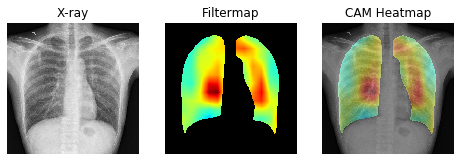

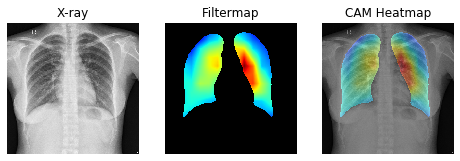

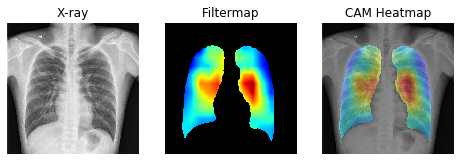

In [0]:
from keras.models import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from scipy.ndimage import zoom

IMG_SIZE = 512
target_size = IMG_SIZE, IMG_SIZE

dataDir = './Visual Explaination from Deep Neural Networks/dataset/samples'
images = sorted(os.listdir(dataDir), reverse=True)
  
def GetandSave_Mask(imgName):
  masksFolder = os.path.join('./Visual Explaination from Deep Neural Networks', 'dataset', 'Extracted Masks')
  if not os.path.exists(masksFolder):
      os.makedirs(masksFolder)
  img = img_to_array(load_img(os.path.join(dataDir, imgName), color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE),
                            interpolation='lanczos'))
  img = np.float32((img-127.0)/127.0)
  img  =img.reshape(-1, 512, 512, 1)
  mask = segmenModel.predict(img)
  save_img(os.path.join(masksFolder, 'mask_'+imgName), mask[0, :, :, :], data_format=None, file_format=None, scale=True)
  
def GetModelInformation(model):
    # we need the output of the activation layer right before the
    # global average pooling (gap) layer and the last dense/softmax
    # layer that generates the class prediction
    before_gap_layer = model.layers[-3]
    class_pred_layer = model.layers[-1]
    outputs = before_gap_layer.output, class_pred_layer.output
    model_layers = Model(inputs=model.input, outputs=outputs)
    # only access the first element of weights, we won't be needing the bias term here
    class_weights = class_pred_layer.get_weights()[0]
    return model_layers, class_weights

model_layers, class_weights = GetModelInformation(classModel)

def GetFiltermap(img, model_layers, class_weights, target_size):
    # before_gap_output will be of shape [1, 7, 7, 2048] for resnet50
    before_gap_output, prediction = model_layers.predict(img)
    predicted_class = np.argmax(prediction)
    dominate_class_weight = class_weights[:, predicted_class]

    # the resizing parameters are hard-coded here for clarity purposes only,
    # we resize the shape of the activation so we can perform a dot product with
    # the dominated class weight, then we reshape it back to the target image size
    # so we can overlay the class activation map on top of our image later
    before_gap_output = np.squeeze(before_gap_output).reshape((-1, 512))
    filtermap = np.dot(before_gap_output, dominate_class_weight).reshape((16, 16))
    # https://stackoverflow.com/questions/13242382/resampling-a-numpy-array-representing-an-image
    filtermap = zoom(filtermap, (32, 32), order=1)
    return filtermap

def GenerateHeatmap(imgName, filtermap):
  mask = img_to_array(load_img(os.path.join('./Visual Explaination from Deep Neural Networks/dataset/Extracted Masks', 'mask_'+imgName), 
                               target_size=(IMG_SIZE, IMG_SIZE), interpolation='lanczos'), dtype='float32')/255.0
  black_pixels_mask = np.all(mask == [0, 0, 0], axis=-1)
  
  img = load_img(os.path.join(dataDir, imgName), target_size=(IMG_SIZE, IMG_SIZE), interpolation='lanczos')
  img = img_to_array(img, dtype='float32')/255.0

  cmap = plt.cm.jet
  norm = plt.Normalize(vmin=filtermap.min(), vmax=filtermap.max())
  filtermap = cmap(norm(filtermap))
  filtermap = array_to_img(filtermap).convert('RGB')
  filtermap = img_to_array(filtermap, dtype='float32')/255.0
  filtermap[black_pixels_mask] = [0, 0, 0]

  superimposed_img = cv2.addWeighted(img, 0.6, filtermap, 0.4, 0)
  
  plt.figure(figsize = (8, 8))
  
  plt.subplot(1, 3, 1)
  plt.imshow(img)
  plt.title('X-ray')
  plt.axis('off')
  
  plt.subplot(1, 3, 2)
  plt.imshow(filtermap)
  plt.title('Filtermap')
  plt.axis('off')
  
  plt.subplot(1, 3, 3)
  plt.imshow(superimposed_img)
  plt.title('CAM Heatmap')
  plt.axis('off')
  plt.imsave('./Visual Explaination from Deep Neural Networks/dataset/CAM Heatmaps/{}'.format(imgName), superimposed_img)
  plt.show()

for imgName in images:
  GetandSave_Mask(imgName)
  img = load_img(os.path.join(dataDir, imgName), target_size=(IMG_SIZE, IMG_SIZE), interpolation='lanczos')
  img = img_to_array(img)/255.0
  img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  predictions = classModel.predict(img)
  if np.argmax(predictions[0])==1:
      filtermap = GetFiltermap(img, model_layers, class_weights, target_size)
      GenerateHeatmap(imgName, filtermap)
      
        
        
    
